In [2]:
import tensorflow
from tensorflow import keras

print(tensorflow.__version__)

2.4.0


In [3]:
import sys
import os 
import numpy as np
import gym

In [8]:
from Performer_Library_Sequential import *
from Function_Library import *
from Environments import *

In [9]:
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy, GreedyQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import FileLogger

import json
import copy
import sys
import os
import shutil
import datetime
import pickle

In [10]:
fixed_configs = {"d": 5,
                "use_Y": False,
                "train_freq": 1,
                "batch_size": 32,
                "print_freq": 250,
                "rolling_average_length": 500,
                "stopping_patience": 500,
                "error_model": "X",
                "c_layers": [[64,3,2],[32,2,1],[32,2,1]],
                "ff_layers": [[512,0.2]],
                "embed_dim": 24,
                "num_heads": 4,
                "ff_dim": 24,
                "method": 'linear',
                "supports": 24,
                "d_rate": 0.0,
                "transformer_depth": 2,
                "max_timesteps": 400000,
                "volume_depth": 5,
                "testing_length": 101,
                "buffer_size": 50000,
                "dueling": True,
                "masked_greedy": False,
                "static_decoder": True}

variable_configs = {"p_phys": 0.001,
                    "p_meas": 0.001,
                    "success_threshold": 10000,
                    "learning_starts": 1000,
                    "learning_rate": 0.00001,
                    "exploration_fraction": 100000,
                    "max_eps": 1.0,
                    "target_network_update_freq": 5000,
                    "gamma": 0.99,
                    "final_eps": 0.02}

all_configs = {}

for key in fixed_configs.keys():
    all_configs[key] = fixed_configs[key]

for key in variable_configs.keys():
    all_configs[key] = variable_configs[key]

In [11]:
from keras.models import load_model

static_decoder = load_model('referee_decoders/nn_d5_X_p5')                                                 
logging_directory = os.path.join("./log_directory/")
logging_path = os.path.join(logging_directory,"training_history.json")
logging_callback = FileLogger(filepath = logging_path,interval = all_configs["print_freq"])

In [12]:
env = Surface_Code_Environment_Multi_Decoding_Cycles(d=all_configs["d"], 
    p_phys=all_configs["p_phys"], 
    p_meas=all_configs["p_meas"],  
    error_model=all_configs["error_model"], 
    use_Y=all_configs["use_Y"], 
    volume_depth=all_configs["volume_depth"],
    static_decoder=static_decoder)

In [13]:
print(env.observation_space.shape)

(6, 11, 11)


In [14]:
memory = SequentialMemory(limit=all_configs["buffer_size"], window_length=1)

policy = LinearAnnealedPolicy(EpsGreedyQPolicy(masked_greedy=all_configs["masked_greedy"]), 
    attr='eps', value_max=all_configs["max_eps"], 
    value_min=all_configs["final_eps"], 
    value_test=0.0, 
    nb_steps=all_configs["exploration_fraction"])

test_policy = GreedyQPolicy(masked_greedy=True)

In [15]:
model = build_semi_performer(all_configs["c_layers"],
                           all_configs["ff_layers"],    
                           all_configs["num_heads"],    
                           all_configs["embed_dim"],
                           all_configs["method"],
                           all_configs["supports"],
                           all_configs["d_rate"],
                           all_configs["transformer_depth"],
                           env.observation_space.shape, 
                           env.num_actions)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 5, 5)          3520      
_________________________________________________________________
activation (Activation)      (None, 64, 5, 5)          0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 64)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 5, 5, 22)          1430      
_________________________________________________________________
lambda (Lambda)              (None, 5, 5, 24)          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 25, 24)            0         
_________________________________________________________________
transformer_block (Transform (None, 25, 24)           

In [16]:
from tensorflow.keras.optimizers import Adam

dqn = DQNAgent(model = model, 
               nb_actions = env.num_actions, 
               memory = memory, 
               nb_steps_warmup = all_configs["learning_starts"], 
               target_model_update = all_configs["target_network_update_freq"], 
               policy = policy,
               test_policy = test_policy,
               gamma = all_configs["gamma"],
               enable_dueling_network=all_configs["dueling"])  


dqn.compile(Adam(lr=all_configs["learning_rate"]))

In [17]:
now = datetime.datetime.now()
started_file = os.path.join(logging_directory,"started_at.p")
pickle.dump(now, open(started_file, "wb" ) )

history = dqn.fit(env, 
  nb_steps=all_configs["max_timesteps"], 
  action_repetition=1, 
  callbacks=[logging_callback], 
  verbose=2,
  visualize=False, 
  nb_max_start_steps=0, 
  start_step_policy=None, 
  log_interval=all_configs["print_freq"],
  nb_max_episode_steps=None, 
  episode_averaging_length=all_configs["rolling_average_length"], 
  success_threshold=all_configs["success_threshold"],
  stopping_patience=all_configs["stopping_patience"],
  min_nb_steps=all_configs["exploration_fraction"],
  single_cycle=False)

Training for 400000 steps ...


/content/drive/My Drive/Colab Notebooks/KerasRLSweke/keras_rl/rl/callbacks.py:443: RuntimeWarning: Mean of empty slice
  mean_metrics = [np.nanmean(lst, axis=0) for lst in metrics]


-----------------
                
Episode: 250
Step: 2237/400000
This Episode Steps: 4
This Episode Reward: 0.0
This Episode Duration: 0.264s
Rolling Lifetime length: 37.320
Best Lifetime Rolling Avg: 45.0
Best Episode: 0
Time Since Best: 249
Has Succeeded: False
Stopped Improving: False
Metrics: mean_eps: 0.151870
Total Training Time: 119.393s

-----------------
                
Episode: 500
Step: 4545/400000
This Episode Steps: 4
This Episode Reward: 0.0
This Episode Duration: 0.265s
Rolling Lifetime length: 38.750
Best Lifetime Rolling Avg: 45.0
Best Episode: 0
Time Since Best: 499
Has Succeeded: False
Stopped Improving: False
Metrics: mean_eps: 0.193937
Total Training Time: 264.677s

-----------------
                
Episode: 750
Step: 6880/400000
This Episode Steps: 11
This Episode Reward: 0.0
This Episode Duration: 0.677s
Rolling Lifetime length: 41.230
Best Lifetime Rolling Avg: 45.0
Best Episode: 0
Time Since Best: 749
Has Succeeded: False
Stopped Improving: False
Metrics: me

In [18]:
weights_file = os.path.join(logging_directory, "dqn_attention_weights.h5f")
dqn.save_weights(weights_file, overwrite=True)

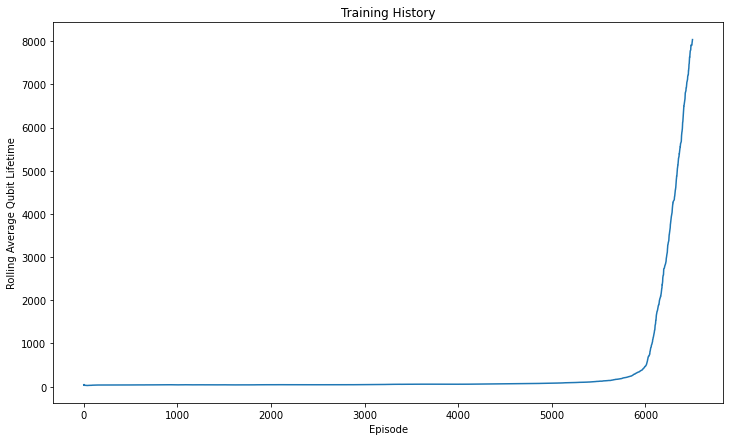

In [19]:
from matplotlib import pyplot as plt
%matplotlib inline

training_history = history.history["episode_lifetimes_rolling_avg"]

plt.figure(figsize=(12,7))
plt.plot(training_history)
plt.xlabel('Episode')
plt.ylabel('Rolling Average Qubit Lifetime')
_ = plt.title("Training History")